In [1]:
import pandas as pd

# import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold 
from sklearn.model_selection import cross_val_score
from sklearn import linear_model, metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler 

df = pd.read_csv('house_data_census.csv')

In [2]:
df = df[df.tracts != '0']
df = df.replace('?', np.nan)
df.sqft_basement = df.sqft_basement.replace('?', np.nan)
df.sqft_basement = df.sqft_basement.astype(float)
df = df.replace(np.nan, 0)
df['compared_to_neighbors'] = df['sqft_living']/df['sqft_living15']
df['lot_compared_to_neighbors'] = df['sqft_lot']/df['sqft_lot15']
df['empty_lot_space'] =  df['sqft_living'] / df['sqft_lot']
#df = df[df.price < 5000000]

In [3]:
df

,field_1,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,Income_Sco,RE_Score,TotalScore,WeightedTo,PercentESL,MedianHous,PercentPOC,compared_to_neighbors,lot_compared_to_neighbors,empty_lot_space
0,0,7129300520,10/13/2014,221900,3,1.00,1180,5650,1.0,0.0,...,3.0,5.0,11.0,3.666667,14.992760,86603.0,76.030012,0.880597,1.000000,0.208850
1,1,6414100192,12/9/2014,538000,3,2.25,2570,7242,2.0,0.0,...,4.0,3.0,10.0,3.333333,16.380283,67397.0,36.749028,1.520710,0.948030,0.354874
2,2,5631500400,2/25/2015,180000,2,1.00,770,10000,1.0,0.0,...,3.0,2.0,7.0,2.333333,8.373317,104053.0,27.658257,0.283088,1.240387,0.077000
3,3,2487200875,12/9/2014,604000,4,3.00,1960,5000,1.0,0.0,...,3.0,1.0,5.0,1.666667,1.203073,103835.0,13.944050,1.441176,1.000000,0.392000
4,4,1954400510,2/18/2015,510000,3,2.00,1680,8080,1.0,0.0,...,1.0,1.0,4.0,1.333333,6.263082,162532.0,18.885848,0.933333,1.076903,0.207921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,21592,263000018,5/21/2014,360000,3,2.50,1530,1131,3.0,0.0,...,4.0,3.0,10.0,3.333333,13.070725,70764.0,44.337511,1.000000,0.749503,1.352785
21593,21593,6600060120,2/23/2015,400000,4,2.50,2310,5813,2.0,0.0,...,4.0,4.0,12.0,4.000000,25.104444,64375.0,56.513483,1.262295,0.807361,0.397385
21594,21594,1523300141,6/23/2014,402101,2,0.75,1020,1350,2.0,0.0,...,3.0,4.0,8.0,2.666667,2.391342,87250.0,50.340374,1.000000,0.672646,0.755556
21595,21595,291310100,1/16/2015,400000,3,2.50,1600,2388,2.0,0.0,...,1.0,3.0,6.0,2.000000,7.201714,149704.0,38.282795,1.134752,1.855478,0.670017


In [4]:
df.columns

Index(['field_1', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'tracts',
       'ESL_Score', 'Income_Sco', 'RE_Score', 'TotalScore', 'WeightedTo',
       'PercentESL', 'MedianHous', 'PercentPOC', 'compared_to_neighbors',
       'lot_compared_to_neighbors', 'empty_lot_space'],
      dtype='object')

In [5]:
df['tract_num'] = df.tracts.str[5:]
df.tract_num  = df.tract_num.astype(int)

In [6]:
X = df.copy()
y = df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)


In [7]:
numeric = ['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15','sqft_above', 
           'grade', 'condition','bathrooms', 'bedrooms', 'yr_built', 
           'compared_to_neighbors', 'empty_lot_space', 'MedianHous']

cats = ['tract_num']

In [8]:
X_train[cats]

,tract_num
15981,10500
9576,32311
1212,21400
18840,1702
20748,30003
...,...
11296,31903
11977,23000
5397,30003
860,27400


In [9]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(X_train[cats])

X_train_encoded = ohe.transform(X_train[cats])
X_test_encoded = ohe.transform(X_test[cats])

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=ohe.get_feature_names())
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=ohe.get_feature_names())
# X_train_ohe = pd.DataFrame(ohe.transform(X_train[['tract_num']]), columns = ohe.get_feature_names())
# X_train_ohe.columns = X_train_ohe.columns.str.replace('x0', 'census_tract')
# X_train = pd.concat([X_train[numeric].reset_index(), X_train_ohe], axis=1)
# #X_train = X_train.drop('index', axis=1)

In [10]:
scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numeric]), columns=numeric)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numeric]), columns=numeric)

In [11]:
X_train_concat = pd.concat([X_train_scaled, X_train_encoded_df], axis=1)
X_test_concat = pd.concat([X_test_scaled, X_test_encoded_df], axis=1)

In [12]:
#X_train['target'] = y_train
#X_train = X_train[np.abs(stats.zscore(X_train['target'])) < 3]
#y_train = X_train['target']
#X_train = X_train.drop('target', axis = 1)

In [13]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [14]:
print('Training features length: ', len(X_train_concat))
print('Testing features length: ', len(X_test_concat))
print('Training target length: ', len(y_train))
print('Testing target length: ', len(y_test))

Training features length:  16178
Testing features length:  5393
Training target length:  16178
Testing target length:  5393


In [15]:
lr = LinearRegression()

In [16]:
lr.fit(X_train_concat, y_train)

LinearRegression()

In [17]:
train_preds = lr.predict(X_train_concat)
test_preds = lr.predict(X_test_concat)

In [18]:
print("r squared", lr.score(X_test_concat, y_test))

r squared 0.8804994257888776


In [19]:
train_error = mean_squared_error(np.exp(y_train), np.exp(train_preds), squared = False)
test_error = mean_squared_error(np.exp(y_test), np.exp(test_preds), squared = False)

In [20]:
train_error, test_error

(137130.5364113896, 137400.4192275774)

In [21]:
def quantile_error(X, y, qant):

    quantiles = pd.DataFrame(pd.qcut(np.exp(y), q=qant))
    e = np.exp(lr.predict(X)) - np.exp(y)
    quantiles['error'] = e
    error_df = quantiles.groupby('price').mean()['error']
    error_df = pd.DataFrame(error_df).reset_index()
    plt.rcParams["figure.figsize"] = (20, 10)
    figure =  error_df.plot.bar(x='price', y='error', rot=45)
    return figure

<AxesSubplot:xlabel='price'>

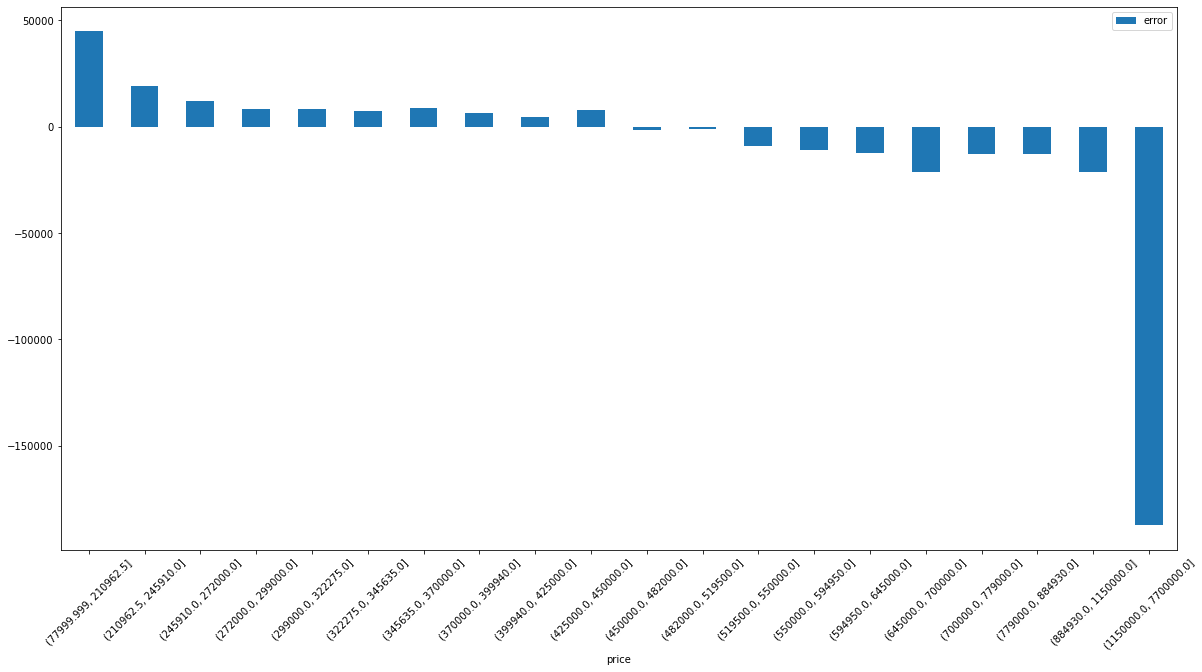

In [22]:
quantile_error(X_train_concat, y_train, 20)

([<matplotlib.axis.XTick at 0x7fb6fdb25580>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

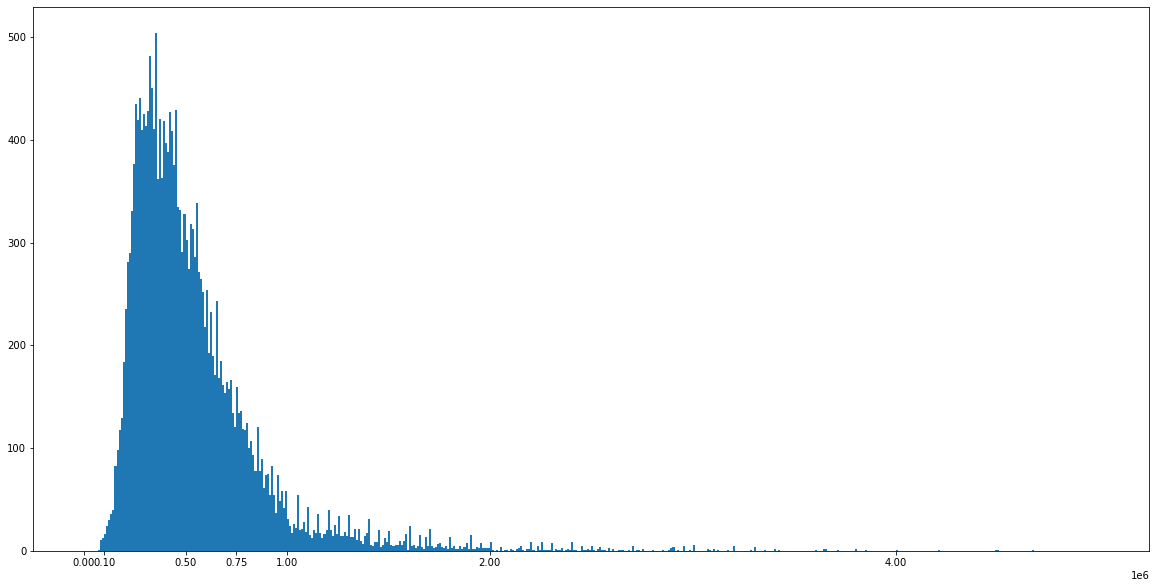

In [36]:
plt.hist('price', bins=500, data=df, range=(0,5000000));
plt.xticks(ticks=[0,100000,500000,750000,1000000,2000000,4000000])

In [ ]:
X_train[(np.exp(y_train) > 5000000)]




In [ ]:
y = X_train.lat
x = X_train.long
plt.scatter(x, y, color='red')
_ = X_train[(np.exp(y_train) < 100000)]
y = _.lat
x = _.long
plt.scatter(x, y, color='green', s=100)

In [ ]:
X_train_concat.columns

In [ ]:
X_train[(np.exp(y_train) > 5000000)]

In [ ]:
x = X_train['empty_lot_space']

In [ ]:
def empty_lot_quantile(X, y, qant):

    quantiles = pd.DataFrame(pd.qcut(np.exp(y), q=qant))
    #e = np.exp(lr.predict(X)) - np.exp(y)
    quantiles['MedianHous'] = X['MedianHous']
    error_df = quantiles.groupby('price').mean()['MedianHous']
    error_df = pd.DataFrame(error_df).reset_index()
    #plt.rcParams["figure.figsize"] = (20, 10)
    figure =  error_df.plot.bar(x='price', y='MedianHous', rot=45)
    plt.xlabel("home price quartiles")
    plt.ylabel("Median Household Income ($)", fontsize=15)
    plt.xlabel("Home Price Quantiles ($)", fontsize=15)
    plt.title('How Census Tract Median Household Income Aligns with Home Price Quantiles', fontsize=20)
    plt.ylim(bottom=60000)
    #figure.plot(figsize = (5,5))
    return figure

In [ ]:
empty_lot_quantile(X_train, y_train, 50)

In [ ]:
def feature_importance(model, X, num=20):
    features = list(X.columns)
    feature_weight = pd.DataFrame(features, columns=['feature'])
    feature_weight['coef'] = model.coef_
    feature_weight['coef_abs'] = np.abs(model.coef_)
    importance = feature_weight.sort_values('coef_abs', ascending=False).iloc[:num]
    plt.figure(figsize=(15,6))
    colors = ['blue' if x > 0 else 'red' for x in importance.coef]
    plt.bar(importance["feature"], importance['coef_abs'], color=colors)
    plt.xticks(rotation=45)
    return importance

In [ ]:
importance = feature_importance(lr.fit(X_train_scaled, y_train), X_train_scaled)